# PEAD - stock market response to events

PEAD: Post/Pre Earning Announcement Drift 



## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

## 1. Import datasets

### Transaction volume & adjusted close data

- Import price-volume data module from KRX using custom lib `korquanttools`
- Import related datasets

In [4]:
# Global parameters

START = 20140101
END = 20220520

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


In [6]:
dollarvolume_df = pricevolume.get_data('dollarvolume')
dollarvolume_df = dollarvolume_df.astype(float)

In [9]:
holidays = dollarvolume_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

In [10]:
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")

### Earnings calendar data

- Import earnings calendar data scraped from investing.com
    - Check data count / unique company count
    - Currently, only small part of calendar data is scraped

In [11]:
earnings_calendar_df = pd.read_pickle('earnings_calendar_20140101-20220530.pickle')

In [12]:
len(earnings_calendar_df)

243

In [13]:
len(earnings_calendar_df['sid'].unique())

141

## 2. Event analysis 

- Process earnings calendar data to lv2 format
- Mix earnings calendar data & dependent variable (dollarvolume, adj.close, etc...) to plot event response graph


In [14]:
# Make calendar event df 
# 1: event day 0: nothing OR does not exist
earnings_calendar_df['is_announced'] = True
earnings_announcement_df = earnings_calendar_df.pivot(index='date', columns='sid', values='is_announced')
earnings_announcement_df = earnings_announcement_df.fillna(False)
earnings_announcement_df = earnings_announcement_df.reindex(index=dollarvolume_df.index, columns=dollarvolume_df.columns)

# Only use tradingdays data
dollarvolume_tradingdays_df = dollarvolume_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]

In [15]:
# Return dolloarvolume data back-and-forth for each event day.
# (5 days backward) _ _ _ _ _ EventDay _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ (20 days forward) 
# D-5 dollarvolume data       D-0                                    D+20 dollarvolume data

def event_by_sid(dollarvolume_df, earnings_announcement_df, d_minus=5, d_plus=20):
    assert dollarvolume_df.shape == earnings_announcement_df.shape
    assert (dollarvolume_df.index == earnings_announcement_df.index).all()
    assert (dollarvolume_df.columns == earnings_announcement_df.columns).all()

    sid_list = dollarvolume_df.columns
    date_list = np.array(dollarvolume_df.index)

    dollarvolume_2d = np.array(dollarvolume_df)
    event_2d = np.array(earnings_announcement_df)
    event_2d = np.where(event_2d == True, event_2d, False)
    
    dollarvolume_data = []
    for col_idx in range(event_2d.shape[1]):
        sid = sid_list[col_idx]

        dollar_col = dollarvolume_2d[:, col_idx]
        col = event_2d[:, col_idx]
        event_indices = np.where(col == True)[0]
        dates = date_list[event_indices]

        for event_idx, date in zip(event_indices, dates):
            start_idx = event_idx - d_minus
            if start_idx < 0:
                start_idx = 0
            
            end_idx = event_idx + d_plus
            if end_idx > len(col):
                end_idx = len(col) - 1
            
            event_period_data = dollar_col[start_idx:end_idx]
            dollarvolume_data.append({
                'sid': sid,
                'd_zero_date': date,
                'data': event_period_data, # TODO: Somewhere, data is becoming object!! 
            })
    
    return dollarvolume_data

In [16]:
dollarvolume_data = event_by_sid(dollarvolume_tradingdays_df, earnings_announcement_tradingdays_df)

In [17]:
# TODO: 여기서 Normalization을 하는 것은 옳지 않다. 
# 단절된 기간들의 data point들의 mean을 구하고 std를 구해서 standardization을 할 것이 아니라, 전체 기간에서 rolling z-score를 우선 구해놓고 이걸 event study에 써야 한다. 

def normalize_before_eventstudy(dollarvolume_data): # TODO: 시총 가중 할 수 있도록. 
    # normalize
    exploded_df = pd.DataFrame(dollarvolume_data).explode('data')
    exploded_df.reset_index(inplace=True, drop=True)
    exploded_df['data'] = exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

    mean_by_sid = exploded_df[['sid', 'data']].groupby('sid').mean()
    mean_by_sid['sid'] = mean_by_sid.index
    mean_by_sid['sid'] = mean_by_sid['sid'].astype(str).apply(lambda x: str(x).zfill(6))
    mean_by_sid.reset_index(inplace=True, drop=True)
    mean_by_sid.rename({'data': 'mean'}, axis=1, inplace=True)
    
    std_by_sid = exploded_df[['sid', 'data']].groupby('sid').std()
    std_by_sid['sid'] = std_by_sid.index
    std_by_sid['sid'] = std_by_sid['sid'].astype(str).apply(lambda x: str(x).zfill(6))
    std_by_sid.reset_index(inplace=True, drop=True)
    std_by_sid.rename({'data': 'std'}, axis=1, inplace=True)
    std_by_sid['std'] += 1e-7

    df = exploded_df.merge(mean_by_sid, on='sid', how='left') # .join DOES NOT WORK! Quirky behavior. Might be an error in pandas. (from Stackoverflow)
    df = df.merge(std_by_sid, on='sid', how='left')

    df['z_score'] = (df['data'] - df['mean']) / df['std']

    return df
    

In [18]:
df = normalize_before_eventstudy(dollarvolume_data)
df['d_date_num'] = df.groupby(['sid', 'd_zero_date']).cumcount() # values (D-5 ~ D+20 dollarvolume) grouped by sid for normalization

In [19]:
final_event_period_data = df.groupby('d_date_num').mean()['z_score']

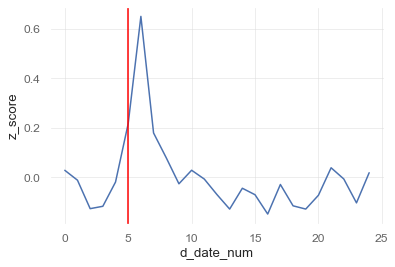

In [20]:
sns.lineplot(x=final_event_period_data.index, y=final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')